## Download AOD files from AERONET

With this notebook we will be able to download AOD files from AERONET for given dates and station. It will also be able to plot a list of given $\rm AOD(\lambda)$.

In [91]:
from selenium import webdriver
import time
import zipfile

First introduce the following variables (all of them as strings):
- site: it will be the station name. For example: site = 'Granada'.
- year, month, day: they will be the initial date. For example: year = '19', month = '4', day = '1'. Note the format of 1 digit numbers (not '%02d').
- year2, month2, day2: they will be the ending date. The same format as the one for year, month and day is needed. Note that if you want the files for just one day, then initial date equals ending date.

Other specified parameters are:
- base: which will be the default initial string of the URL.
- AOD20: that will allow to download level 2.0 files (ensure these 2.0 files are available for your temporal range).
- AVG. (not sure what this means).
- chromedriver_location: it will be the location of the chrome drive needed for this tool. If unchanged, it will be located in the same folder as the notebook. 

In [92]:
#-------------------------------------------------------------------------------------------------------------------------------
site = 'Granada'
year = '19'
month = '1'
day = '1'
year2 = '19'
month2 = '1'
day2 = '31'
#Just check in case of error
base = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_warning_v3?'
AOD20 = '1'
AVG = '10'
chromedriver_location = 'chromedriver'
#-------------------------------------------------------------------------------------------------------------------------------

Then we proceed to download the specified data from AERONET.

In [93]:
path = base + 'site=' + site + '&year=1' + year + '&month=' + month + '&day=' + day + \
       '&year2=1' + year2 + '&month2=' + month2 + '&day2=' + day2 + '&AOD20=' + AOD20 + '&AVG=' + AVG

driver = webdriver.Chrome(chromedriver_location)
driver.get(path)
try:
    src = driver.find_elements_by_xpath("//*[contains(text(), 'Download')]")
    print('Data specifications are valid')
    time.sleep(5)
    base = 'https://aeronet.gsfc.nasa.gov/zip_files/V3/'
    path = base + '20' + year + format(int(month), '02d') + format(int(day), '02d') + '_' + \
           '20' + year2 + format(int(month2), '02d') + format(int(day2), '02d') + '_' + site + '.zip'
    try:
        driver2 = webdriver.Chrome(chromedriver_location)
        driver2.get(path)
        print('Files downloaded')
        driver.quit()
        driver2.quit()
    except:
        print('Unable to download files')
except:
    print('Unable to find the specifications')

Data specifications are valid
Files downloaded


Once the data is downloaded we proceed to unzip the file and plot it.

In [94]:
#This cell has been downloaded from http://blog.rtwilson.com/reading-aeronet-data-in-pandas-a-simple-helper-function/
import pandas as pd

def read_aeronet(filename):
    """Read a given AERONET AOT data file, and return it as a dataframe.
    
    This returns a DataFrame containing the AERONET data, with the index
    set to the timestamp of the AERONET observations. Rows or columns
    consisting entirely of missing data are removed. All other columns
    are left as-is.
    """
    dateparse = lambda x: pd.datetime.strptime(x, "%d:%m:%Y %H:%M:%S")
    aeronet = pd.read_csv(filename, skiprows=6, na_values=['N/A'],
                          parse_dates={'times':[0,1]},
                          date_parser=dateparse)

    aeronet = aeronet.set_index('times')
    #del aeronet['Julian_Day']
    
    # Drop any rows that are all NaN and any cols that are all NaN
    # & then sort by the index
    an = (aeronet.dropna(axis=1, how='all')
                .dropna(axis=0, how='all')
                .rename(columns={'Last_Processing_Date(dd/mm/yyyy)': 'Last_Processing_Date'})
                .sort_index())

    return an

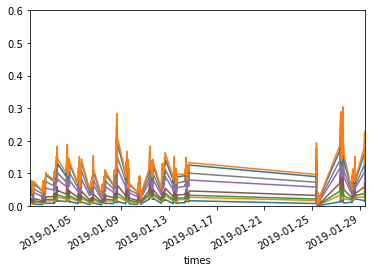

In [95]:
base = 'C:\\Users\\usuario\\Downloads\\20' + format(int(year), '02d') + format(int(month), '02d') + \
        format(int(day), '02d') + '_20' + format(int(year2), '02d') + format(int(month2), '02d') + \
        format(int(day2), '02d') + '_' + site
zip_file_path = base + '.zip'
data_file_path = base + '.lev20'
extracting_path = 'C:\\Users\\usuario\\Downloads\\'
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracting_path)

    data = read_aeronet(data_file_path)
    AOD_keys = []
    for key in data.keys():
        if 'AOD_' in key and not 'AOD_E' in key:
            AOD_keys.append(key)

    data[AOD_keys].plot(legend = False, ylim = (0,0.6))
except:
    print('Failed extracting file')